In [1]:
#Program by Andrew M. Evans
#The goal of this program is to import data from a .txt file, parse data, process data invariant mass output, and 
#repackage the data in a new .txt following a similar format

In [2]:
import ROOT
import numpy as np
import os
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.26/00


In [3]:
#Creating particle class to group propeties of particles given
class Particle: 
    def __init__(self, pt, eta, phi, m): #imported as strings, float() use to fix
        self.pt = float(pt) 
        self.eta = float(eta)
        self.phi = float(phi)
        self.m = float(m)
        self.p = np.array([0.0,0.0,0.0])
        self.vec4 = np.array([0.0,0.0,0.0,0.0])
    
    def calc_vec4(self):
        px = self.pt*np.cos(self.phi)
        py = self.pt*np.sin(self.phi)
        pz = self.pt*np.sinh(self.eta)
        self.p = np.array([px,py,pz])
        mag_p = np.sqrt(px*px + py*py + pz*pz)
        E = self.pt*np.cosh(self.eta)
        self.vec4 = np.array([E, px, py, pz])
    
    def invariant_mass1(self, p2): #Finds the invariant mass of a two particle collision, centered below 500
        M = np.sqrt(2*self.pt*p2.pt*(np.cosh(self.eta-p2.eta)-np.cos(self.phi-p2.phi)))
        return M
    
    def invariant_mass2(self, p2): #curve centered above 750
        P1dotP2 = np.dot(self.p, p2.p)
        E1E2 = self.vec4[0]*p2.vec4[0]
        M = np.sqrt(self.m**2 + p2.m**2 + 2*(E1E2-P1dotP2)) #
        return M
    
    def invariant_mass3(self, p2): #curve centered above 750
        M = np.sqrt((self.vec4[0]+p2.vec4[0])**2 - np.linalg.norm(self.p+p2.p)**2) 
        return M
    
    
 

In [4]:
#defining function for unpacking the zip file
def data_unpack(file):
    f = open(file, "r")
    Lines = f.readlines()
    count = 0
    temp, output = [], []
    for line in Lines:
        if(count % 5 == 0):
            if(count): #true for anything other than 0
                output.append(temp)
            temp = [] #clears temp for the new [(run, event), m1, m2]
            data = line[:-1].split(" ")
            temp.append((data[1], data[3])) #(run, event)
        if(count % 5 == 2 or count % 5 == 3):
            data = line[:-1].split(" ")
            temp.append((data[2],data[3],data[4],data[5]))
        count += 1
    f.close()
    return output

In [5]:
#taking the unpacked data and instantiating particles with the data
def data_to_particle(data):
    return [[data[0], Particle(i[0], i[1], i[2], i[3])] for i in data[1:]] #creates a list of lists where the first
                                                                    # element of any sublist is the (Run, Event), and
                                                                    # the second is the particle with the data input

In [6]:
#calculates the invariant mass of the particle and packages this into a list with the (Run, Event)
def total_m(data): 
    data[0][1].calc_vec4()
    data[1][1].calc_vec4()
    m1 = data[0][1]
    m2 = data[1][1]
    return [data[0], m1.invariant_mass3(m2)] #change the number for other methods of M calc. (1-3)
    
    

In [7]:
#Takes the (Run, Event) particle lists and formats them in the text file correctly
def data_packager(data, output = "./final_mass.txt"):
    os.remove(output)#should be changed to work when the file doesn't exist
    f = open(output, "a")
    for i in data:
        run = i[0][0][0]
        event = i[0][0][1]
        f.write("Run "+str(run)+" Event "+str(event)+"\n")
        f.write("m = "+str(i[1])+"\n\n")#add the Run and event
    f.close()

In [8]:
#main loop
parsed_data = data_unpack('/Users/gk/Documents/muon_mass_calculation/muons.txt')
total_mass_list = []
for i in parsed_data:
    total_mass_list.append(total_m(data_to_particle(i)))
data_packager(total_mass_list)

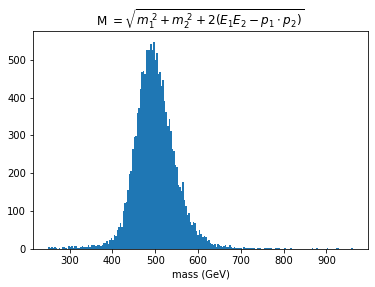

In [14]:
#for plotting a histogram of the mass data
mass = []
for i in total_mass_list:
    mass.append(i[1])
n_bins = 200
fig, ax = plt.subplots()
plt.title(r'M $= \sqrt{m_1^{ \ 2} +m_2^{ \ 2} +2 \left( E_1 E_2 - p_1 \cdot p_2 \right)}$') #2*(E1E2-P1dotP2)
#plt.title(r'M $= \sqrt{\left( E_1 + E_2\right)^2 - \left|p_1 + p_2 \right|^2}$')
#plt.title(r'M $= \sqrt{2 \cdot p_{T1} p_{T2}\left( \cosh \left( \eta_1-\eta_2 \right) - \cos \left( \phi_1 - \phi_2 \right) \right)}$')
ax.set_xlabel('mass (GeV)')
# We can set the number of bins with the *bins* keyword argument.
ax.hist(mass, bins=n_bins)
plt.show()